## INF8953DE (Fall 2021) : Reinforcement Learning - Assignment 2
## Amine EL AMERI - Matricule: 2164634

#### This notebook has only been tested on Colab

#### Environment

In [117]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 6]

In [118]:
!pip install gym
#!pip install git+https://github.com/micklethepickle/modified-frozen-lake.git

In [119]:
!pip install requests
import requests
url = 'https://raw.githubusercontent.com/micklethepickle/modified-frozen-lake/main/frozen_lake.py'
r = requests.get(url)

with open('frozen_lake.py', 'w') as f:
    f.write(r.text)

# now we can import frozen_lake
from frozen_lake import *

#### 1 Monte Carlo Methods

In [120]:
env = FrozenLakeEnv(map_name="4x4", slip_rate=0.1)

##### Q1

In [121]:
def generate_random_policy():
  policy = np.empty(16, dtype=object)
  for i in range(16):
    proba_distri = np.random.random(4)
    proba_distri /= proba_distri.sum()
    policy[i] = proba_distri
  return policy

In [122]:
def generate_episode(policy, env, render):
  states = []
  actions = []
  rewards = []

  current_state = env.reset()
  states.append(current_state)
  if render:
    env.render()

  done = False
  while not done:
    #action = np.argmax(policy[current_state])
    action = np.random.choice(4, 1, p = policy[current_state] )[0]
    next_state, reward, done, extra = env.step(action)
    current_state = next_state

    if render:
      env.render()

    actions.append(action)
    states.append(next_state)
    rewards.append(reward)

  return states, actions, rewards

In [123]:
randPolicy = generate_random_policy()

##### Q2

In [124]:
def generate_eps_soft_random_policy(eps):
  policy = np.empty(16, dtype=object)
  for i in range(16):
    proba_distri = np.zeros(4)
    while not all(j >= (eps/4) for j in proba_distri):
      proba_distri = np.random.random(4)
      proba_distri /= proba_distri.sum()
    policy[i] = proba_distri
  return policy

In [125]:
def first_visit_MC_control(env, eps, nRuns, nEpisodes):
  gamma = 0.99
  average_return_Q2a = [0]*nEpisodes
  average_return_last_100_Q2c = [0]*100

  for run in range(nRuns):

    policy = generate_eps_soft_random_policy(eps)
    Q = np.random.random((16, 4))
    Returns = [ [ [] for i in range(4) ] for j in range(16) ]

    for epis in range(nEpisodes):
      # know in wich episode we are
      print("\rRun number {}/{}, episode number {}/{}.".format(run, nRuns, epis, nEpisodes), end="")
      sys.stdout.flush()

      already_seen = {}
      states, actions, rewards = generate_episode(policy, env, False)
      average_return_Q2a[epis] += sum(rewards) # for the Q2)a plot
      if epis>=(nEpisodes-100): # Q2)c
        average_return_last_100_Q2c[epis - (nEpisodes-100)] += sum(rewards) 
      G = 0
      for step in reversed(range(len(actions))):
        G = gamma*G + rewards[step]
        if not ((states[step], actions[step]) in already_seen.keys()):
          already_seen[(states[step], actions[step])] = 1
          Returns[states[step]][actions[step]].append(G)
          Q[states[step]][actions[step]] = np.mean(Returns[states[step]][actions[step]])
          A_star = np.argmax(Q[states[step]])
          for action in range(4):
            if action == A_star:
              policy[states[step]][action] = 1 - eps + eps/4
            else:
              policy[states[step]][action] = eps/4
  average_return_Q2a = list(np.array(average_return_Q2a)/nRuns)
  average_return_last_100_Q2c = np.mean(np.array(average_return_last_100_Q2c)/nRuns)
  return policy, average_return_Q2a, average_return_last_100_Q2c

In [126]:
policy_Q2b, average_return_Q2a, average_return_last_100_Q2c = first_visit_MC_control(env, 0.05, 10, 2000)

Run number 9/10, episode number 1999/2000.

In [127]:
policy_Q2b

array([array([0.0125, 0.0125, 0.0125, 0.9625]),
       array([0.0125, 0.0125, 0.9625, 0.0125]),
       array([0.0125, 0.9625, 0.0125, 0.0125]),
       array([0.9625, 0.0125, 0.0125, 0.0125]),
       array([0.0125, 0.0125, 0.0125, 0.9625]),
       array([0.9625, 0.0125, 0.0125, 0.0125]),
       array([0.0125, 0.9625, 0.0125, 0.0125]),
       array([0.9625, 0.0125, 0.0125, 0.0125]),
       array([0.0125, 0.0125, 0.0125, 0.9625]),
       array([0.0125, 0.9625, 0.0125, 0.0125]),
       array([0.0125, 0.9625, 0.0125, 0.0125]),
       array([0.9625, 0.0125, 0.0125, 0.0125]),
       array([0.9625, 0.0125, 0.0125, 0.0125]),
       array([0.0125, 0.0125, 0.9625, 0.0125]),
       array([0.0125, 0.0125, 0.9625, 0.0125]),
       array([0.9625, 0.0125, 0.0125, 0.0125])], dtype=object)

Text(0.5, 1.0, 'Average undiscounted return across the 10 different runs')

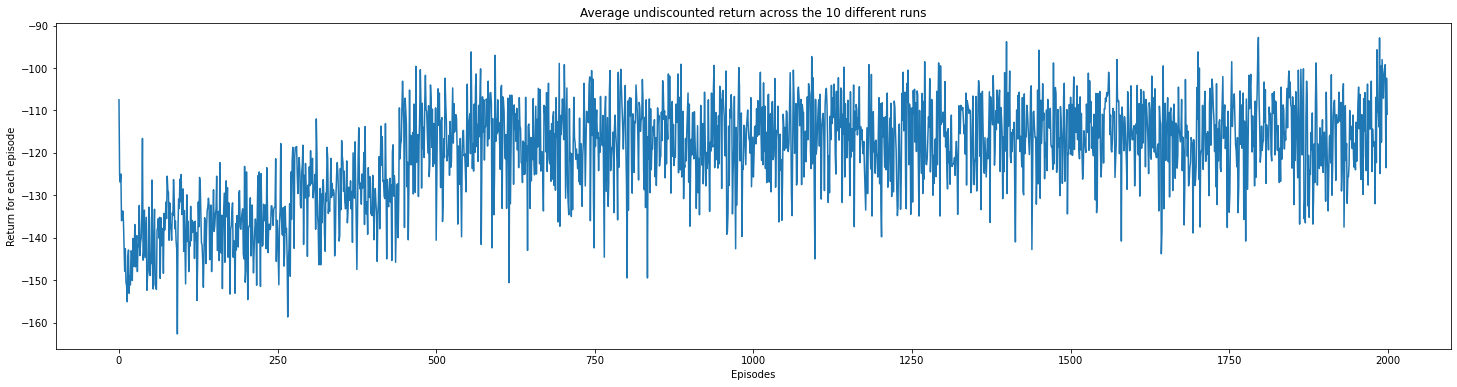

In [128]:
# Q2)a
plt.rcParams['figure.figsize'] = [25, 6]
fig, ax = plt.subplots()
ax.plot(range(2000), average_return_Q2a)
ax.set_xlabel("Episodes")
ax.set_ylabel("Return for each episode")
ax.set_title("Average undiscounted return across the 10 different runs")

In [129]:
#Q2)b
print(policy_Q2b)
_, _, _ = generate_episode(policy_Q2b, env, True)

[array([0.0125, 0.0125, 0.0125, 0.9625])
 array([0.0125, 0.0125, 0.9625, 0.0125])
 array([0.0125, 0.9625, 0.0125, 0.0125])
 array([0.9625, 0.0125, 0.0125, 0.0125])
 array([0.0125, 0.0125, 0.0125, 0.9625])
 array([0.9625, 0.0125, 0.0125, 0.0125])
 array([0.0125, 0.9625, 0.0125, 0.0125])
 array([0.9625, 0.0125, 0.0125, 0.0125])
 array([0.0125, 0.0125, 0.0125, 0.9625])
 array([0.0125, 0.9625, 0.0125, 0.0125])
 array([0.0125, 0.9625, 0.0125, 0.0125])
 array([0.9625, 0.0125, 0.0125, 0.0125])
 array([0.9625, 0.0125, 0.0125, 0.0125])
 array([0.0125, 0.0125, 0.9625, 0.0125])
 array([0.0125, 0.0125, 0.9625, 0.0125])
 array([0.9625, 0.0125, 0.0125, 0.0125])]

SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG


In [130]:
#Q2)c
print(f"The average undiscounted return for the last 100 episodes of the 10 runs: {average_return_last_100_Q2c}")

The average undiscounted return for the last 100 episodes of the 10 runs: -115.22900000000001


##### Q3

In [131]:
def generate_policy_b():
  policy = np.empty(16, dtype=object)
  for i in range(16):
    proba_distri = np.full(4, 0.25, dtype=np.float64)
    policy[i] = proba_distri
  return policy
  
policy_b = generate_policy_b()

In [132]:
def V_from_Q(Q):
  optimal_V = np.zeros(Q.shape[0])
  state = 0
  for a_vals in Q:
      greedy_action = np.max(a_vals)
      optimal_V[state] = greedy_action
      state += 1
  return optimal_V

In [133]:
# policy_Q2b is the policy found in question 2

def MC_ordinary_importance_sampling(env, policy_b, policy_Q2b, nRuns, nEpisodes):
  gamma = 0.99

  experiments_ordinary_s0 = np.zeros((nRuns, nEpisodes))
  experiments_ordinary_s3 = np.zeros((nRuns, nEpisodes))
  experiments_ordinary_s7 = np.zeros((nRuns, nEpisodes))
  experiments_ordinary_s14 = np.zeros((nRuns, nEpisodes))

  for run in range(nRuns):

    Q = np.random.random((16, 4))
    C = np.zeros((16, 4))
    for epis in range(nEpisodes):

      print("\rRun number {}/{}, episode number {}/{}.".format(run, nRuns, epis, nEpisodes), end="")
      sys.stdout.flush()

      states, actions, rewards = generate_episode(policy_b, env, False)
      G, W = 0, 1
      for step in reversed(range(len(actions))):
        G = gamma*G + rewards[step]
        C[states[step]][actions[step]] = C[states[step]][actions[step]] + W
        Q[states[step]][actions[step]] = Q[states[step]][actions[step]] + (W*(G - Q[states[step]][actions[step]]))/ C[states[step]][actions[step]]
        V = V_from_Q(Q)
        experiments_ordinary_s0[run][epis] = V[0]
        experiments_ordinary_s3[run][epis] = V[3]
        experiments_ordinary_s7[run][epis] = V[7]
        experiments_ordinary_s14[run][epis] = V[14]

        
  return experiments_ordinary_s0, experiments_ordinary_s3, experiments_ordinary_s7, experiments_ordinary_s14

In [134]:
# policy_Q2b is the policy found in question 2

def MC_weighted_importance_sampling(env, policy_b, policy_Q2b, nRuns, nEpisodes):
  gamma = 0.99

  experiments_weighted_s0 = np.zeros((nRuns, nEpisodes))
  experiments_weighted_s3 = np.zeros((nRuns, nEpisodes))
  experiments_weighted_s7 = np.zeros((nRuns, nEpisodes))
  experiments_weighted_s14 = np.zeros((nRuns, nEpisodes))

  for run in range(nRuns):

    Q = np.random.random((16, 4))
    C = np.zeros((16, 4))
    for epis in range(nEpisodes):

      print("\rRun number {}/{}, episode number {}/{}.".format(run, nRuns, epis, nEpisodes), end="")
      sys.stdout.flush()

      states, actions, rewards = generate_episode(policy_b, env, False)
      G, W = 0, 1
      for step in reversed(range(len(actions))):
        G = gamma*G + rewards[step]
        C[states[step]][actions[step]] = C[states[step]][actions[step]] + W
        Q[states[step]][actions[step]] = Q[states[step]][actions[step]] + (W*(G - Q[states[step]][actions[step]]))/ C[states[step]][actions[step]]
        W = (W * policy_Q2b[states[step]][actions[step]]) / policy_b[states[step]][actions[step]]
        V = V_from_Q(Q)
        experiments_weighted_s0[run][epis] = V[0]
        experiments_weighted_s3[run][epis] = V[3]
        experiments_weighted_s7[run][epis] = V[7]
        experiments_weighted_s14[run][epis] = V[14]

  return experiments_weighted_s0, experiments_weighted_s3, experiments_weighted_s7, experiments_weighted_s14

In [135]:
#I use the last policy found in 2: policy_Q2b
experiments_weighted_s0, experiments_weighted_s3, experiments_weighted_s7, experiments_weighted_s14 = MC_weighted_importance_sampling(env, policy_b, policy_Q2b, nRuns=10, nEpisodes=2000)

Run number 9/10, episode number 1999/2000.

In [136]:
#I use the last policy found in 2: policy_Q2b
experiments_ordinary_s0, experiments_ordinary_s3, experiments_ordinary_s7, experiments_ordinary_s14 = MC_ordinary_importance_sampling(env, policy_b, policy_Q2b, nRuns=10, nEpisodes=2000)

Run number 9/10, episode number 1999/2000.

In [137]:
def plot_many(experiments, label=None, color=None):
  mean_exp = np.mean(experiments, axis=0)
  std_exp = np.std(experiments, axis=0)
  plt.plot(mean_exp, color=color, label=label)
  plt.legend(loc = "best")
  plt.xlabel("episodes")
  plt.ylabel("average off policy Monte Carlo estimates of")
  plt.fill_between(range(len(experiments[0])), mean_exp + std_exp,
    mean_exp - std_exp, color=color, alpha=0.1)

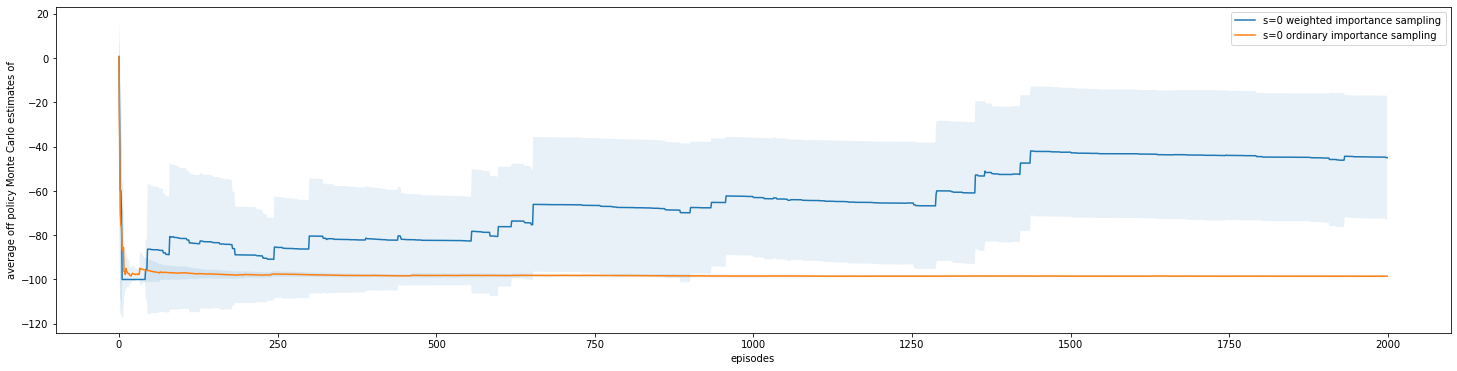

In [138]:
plot_many(experiments_weighted_s0, label="s=0 weighted importance sampling", color=None)
plot_many(experiments_ordinary_s0, label="s=0 ordinary importance sampling", color=None)

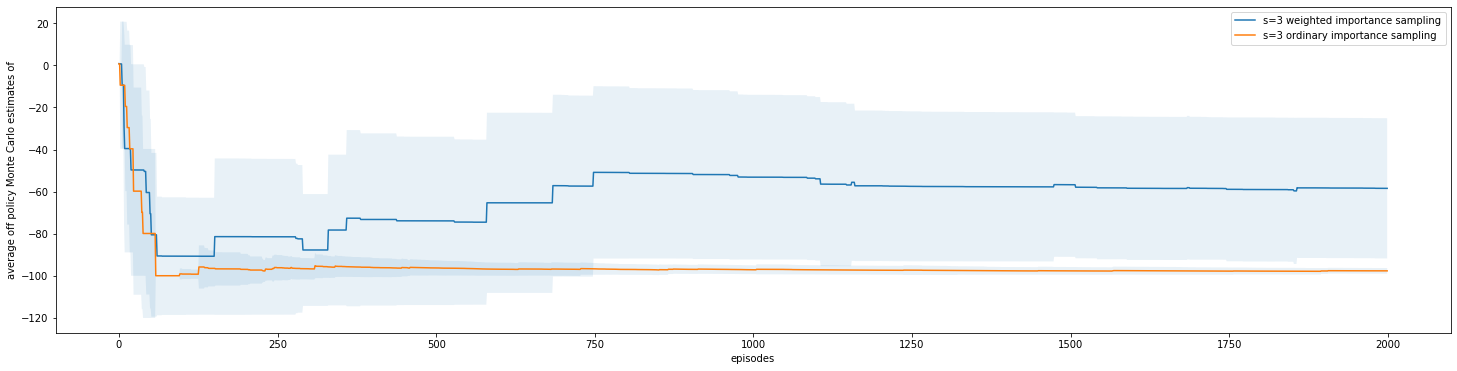

In [139]:
plot_many(experiments_weighted_s3, label="s=3 weighted importance sampling", color=None)
plot_many(experiments_ordinary_s3, label="s=3 ordinary importance sampling", color=None)

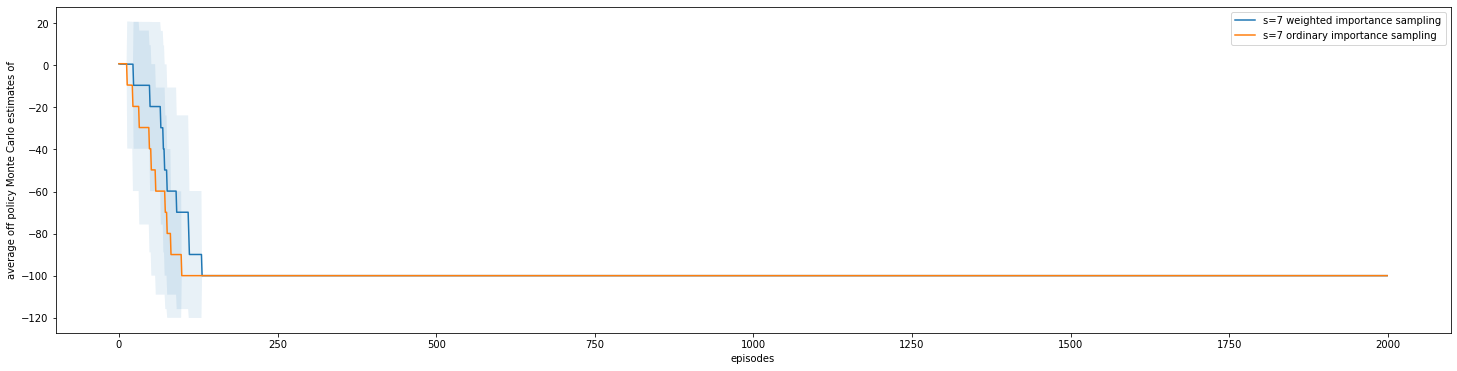

In [140]:
plot_many(experiments_weighted_s7, label="s=7 weighted importance sampling", color=None)
plot_many(experiments_ordinary_s7, label="s=7 ordinary importance sampling", color=None)

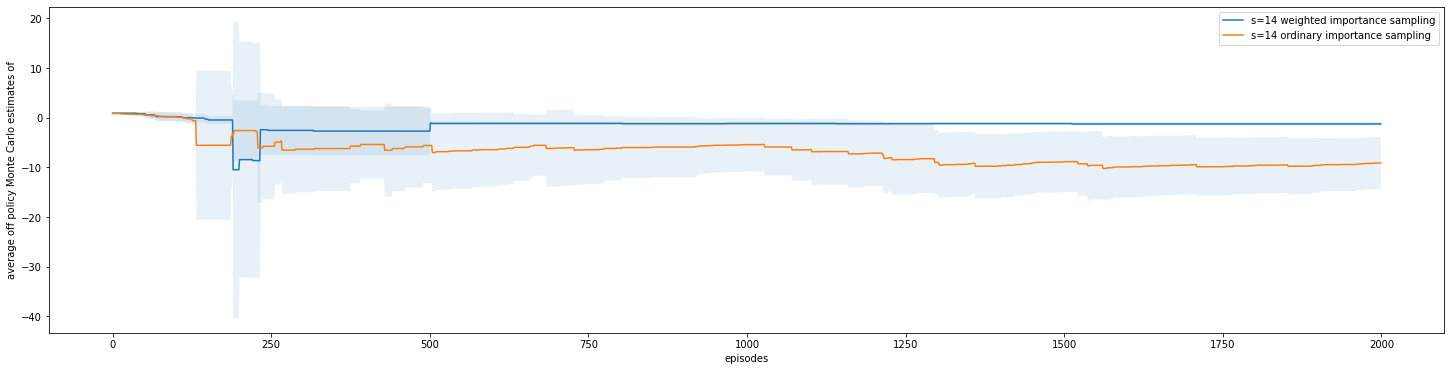

In [141]:
plot_many(experiments_weighted_s14, label="s=14 weighted importance sampling", color=None)
plot_many(experiments_ordinary_s14, label="s=14 ordinary importance sampling", color=None)

#### 2 Prediction: Unifying Monte Carlo methods and Temporal Difference Learning

In [142]:
env2 = FrozenLakeEnv(map_name="4x4-easy", slip_rate=0)

##### Q1

In [143]:
def every_visit_MC_control(env, nEpisodes):

  gamma = 0.99
  policy = generate_policy_b()
  V = np.random.random(16)
  Returns = [[] for i in range(16)]
  Q21a_plot = np.zeros((16, nEpisodes))

  for epis in range(nEpisodes):

    print("\rEpisode number {}/{}.".format(epis, nEpisodes), end="")
    sys.stdout.flush()

    states, actions, rewards = generate_episode(policy, env, False)
    G = 0

    for step in reversed(range(len(actions))):
      G = gamma*G + rewards[step]
      Returns[states[step]].append(G)
      V[states[step]] = np.mean(Returns[states[step]])
    
    Q21a_plot[:, epis] = V.T

  return Q21a_plot, V

In [144]:
Q21a_plot, Q21b_V = every_visit_MC_control(env2, nEpisodes = 10000)

Episode number 9999/10000.

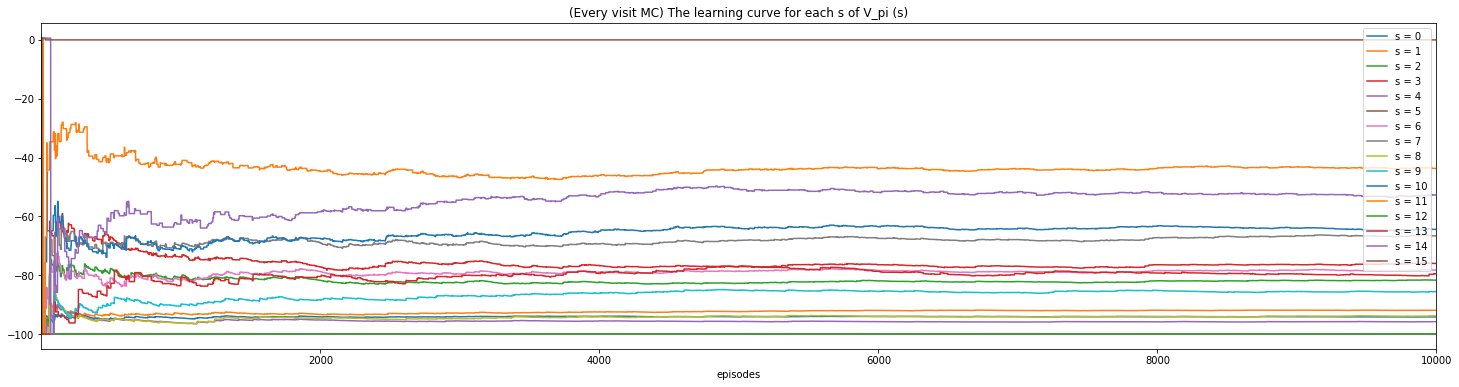

In [145]:
fig, ax = plt.subplots()
for state in range(Q21a_plot.shape[0]):
  lbl = "s = " + str(state)
  ax.plot(np.arange(1, Q21a_plot.shape[1]+1), Q21a_plot[state], label = lbl)

ax.set_xlabel("episodes")
ax.set_xlim([1, Q21a_plot.shape[1]])
ax.set_title("(Every visit MC) The learning curve for each s of V_pi (s)")
ax.legend(loc='upper right')

In [146]:
print(f" The final learned value function (Every visit MC): ")
Q21b_V

 The final learned value function (Every visit MC): 


array([ -94.19344576,  -91.94502905,  -81.71176753,  -76.03356998,
        -95.81082184, -100.        ,  -78.2972532 ,  -66.65573224,
        -93.84666078,  -85.59927008,  -64.43955258,  -43.72364272,
       -100.        ,  -79.57110723,  -52.74028852,    0.        ])

##### Q2

In [147]:
def TD_0_prediction(env, alpha, nEpisodes):

  gamma = 0.99
  policy = generate_policy_b()
  V = np.random.random(16)
  V[15] = 0

  Q22_plot = np.zeros((16, nEpisodes))

  for epis in range(nEpisodes):

    print("\rEpisode number {}/{}.".format(epis, nEpisodes), end="")
    sys.stdout.flush()

    states, actions, rewards = generate_episode(policy, env, False)

    for step in range(len(actions)):

      V[states[step]] = V[states[step]] + alpha*( rewards[step] + gamma*V[states[step+1]] - V[states[step]] )
    
    Q22_plot[:, epis] = V.T

  return Q22_plot

In [148]:
Q22_plot = TD_0_prediction(env2, alpha=0.01, nEpisodes=10000)

Episode number 9999/10000.

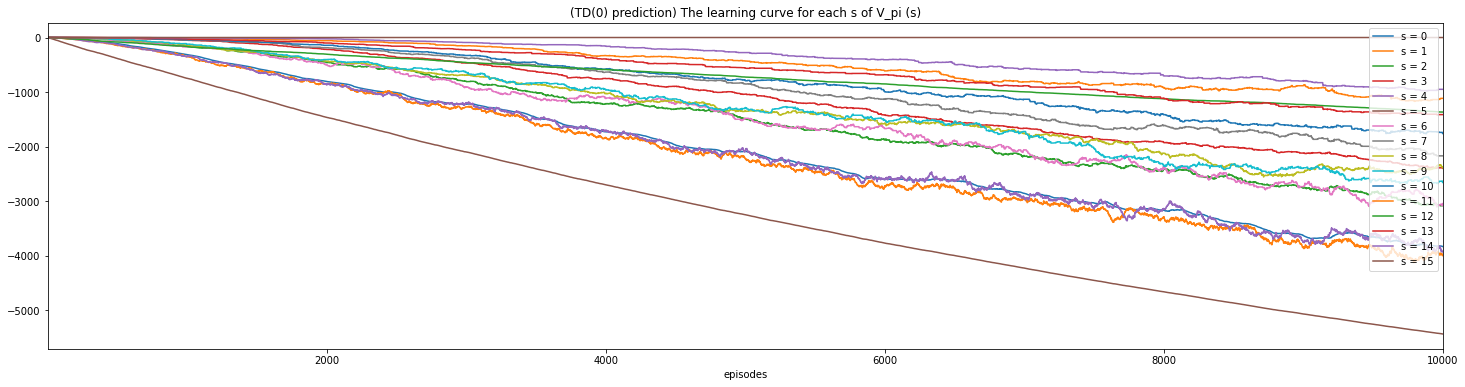

In [149]:
fig, ax = plt.subplots()
for state in range(Q22_plot.shape[0]):
  lbl = "s = " + str(state)
  ax.plot(np.arange(1, Q22_plot.shape[1]+1), Q22_plot[state], label = lbl)

ax.set_xlabel("episodes")
ax.set_xlim([1, Q22_plot.shape[1]])
ax.set_title("(TD(0) prediction) The learning curve for each s of V_pi (s)")
ax.legend(loc='upper right')

In [173]:
Q22_plot_2 = TD_0_prediction(env2, alpha=0.1, nEpisodes=10000)

Episode number 9999/10000.

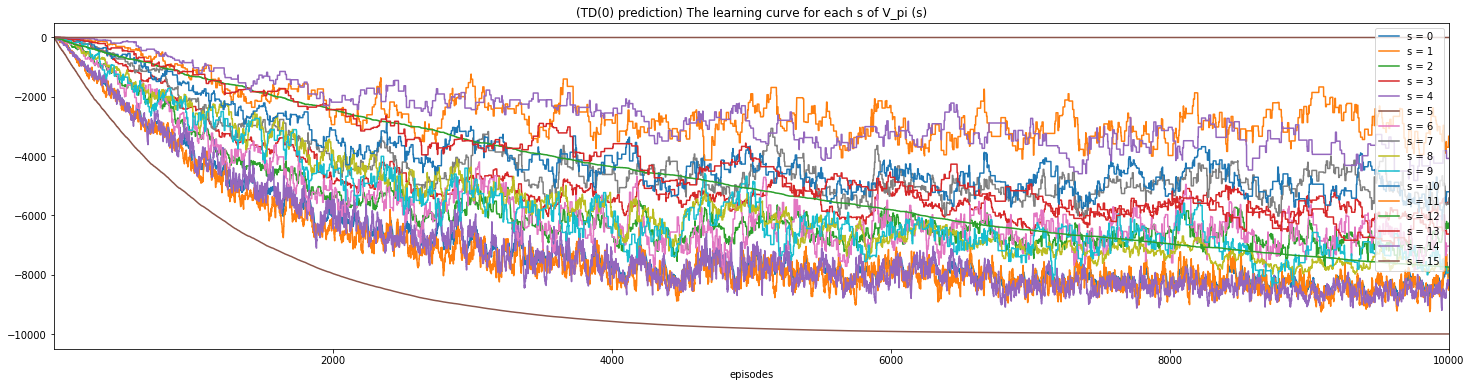

In [174]:
fig, ax = plt.subplots()
for state in range(Q22_plot_2.shape[0]):
  lbl = "s = " + str(state)
  ax.plot(np.arange(1, Q22_plot_2.shape[1]+1), Q22_plot_2[state], label = lbl)

ax.set_xlabel("episodes")
ax.set_xlim([1, Q22_plot_2.shape[1]])
ax.set_title("(TD(0) prediction) The learning curve for each s of V_pi (s)")
ax.legend(loc='upper right')

##### Q3

In [150]:
def n_step_TD(env, alpha, n, nEpisodes):

  gamma = 0.99
  policy = generate_policy_b()
  V = np.random.random(16)
  Q23_plot = np.zeros((16, nEpisodes))

  for epis in range(nEpisodes):
    
    print("\rEpisode number {}/{}.".format(epis, nEpisodes), end="")
    sys.stdout.flush()

    states, actions, rewards = generate_episode(policy, env, False)
    t = 0
    T = np.inf

    while True:
      if t < T:
        if (t+1) >= (len(actions)-1):
          T = t+1

      Tau = t-n+1

      if Tau >= 0:
        G = 0
        for i in range(Tau+1, min(Tau+n, T)+1):
            G = G + (gamma**(i-Tau-1)) * rewards[i]

        if (Tau+n) < T:
            G = G + (gamma**n) * V[states[Tau+n]]

        V[states[Tau]] = V[states[Tau]] + alpha*(G - V[states[Tau]])

      if Tau == T-1:
        break

      t += 1

    Q23_plot[:, epis] = V.T

  return Q23_plot

In [151]:
Q23_plot = n_step_TD(env2, alpha=0.01, n=1, nEpisodes=10000)

Episode number 9999/10000.

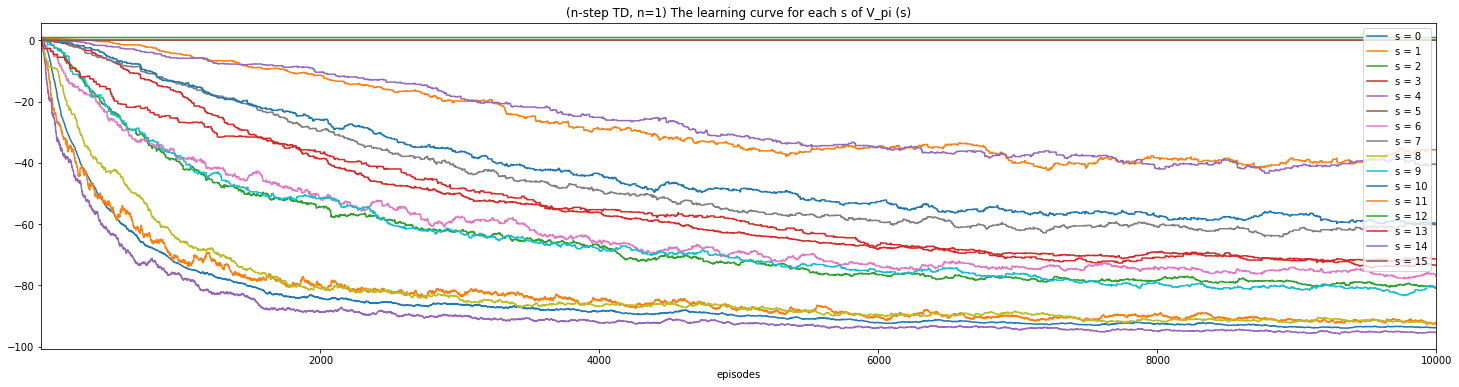

In [152]:
fig, ax = plt.subplots()
for state in range(Q23_plot.shape[0]):
  lbl = "s = " + str(state)
  ax.plot(np.arange(1, Q23_plot.shape[1]+1), Q23_plot[state], label = lbl)

ax.set_xlabel("episodes")
ax.set_xlim([1, Q23_plot.shape[1]])
ax.set_title("(n-step TD, n=1) The learning curve for each s of V_pi (s)")
ax.legend(loc='upper right')

##### Q4

In [153]:
Q24_plot = n_step_TD(env2, alpha=0.01, n=100, nEpisodes=10000)

Episode number 9999/10000.

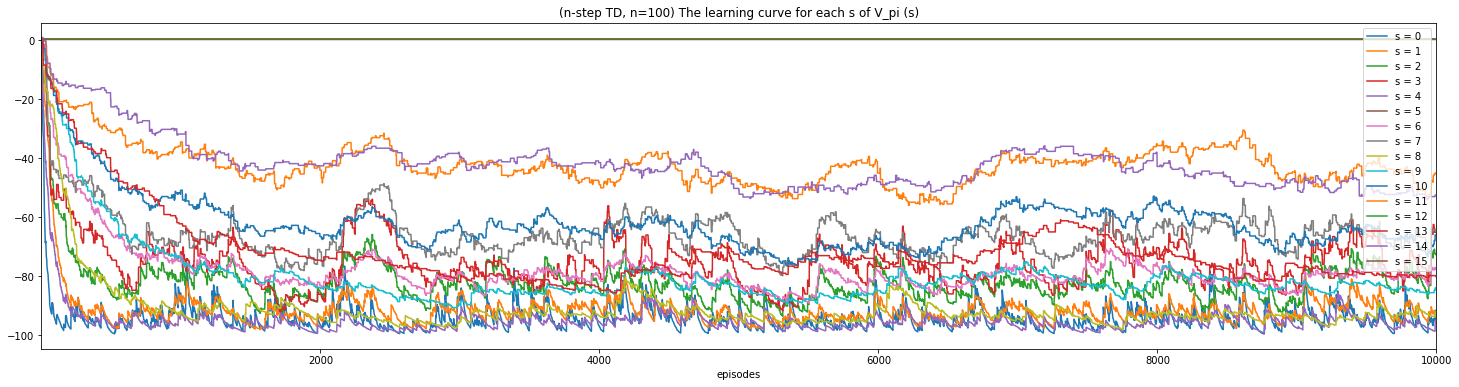

In [154]:
fig, ax = plt.subplots()
for state in range(Q24_plot.shape[0]):
  lbl = "s = " + str(state)
  ax.plot(np.arange(1, Q24_plot.shape[1]+1), Q24_plot[state], label = lbl)

ax.set_xlabel("episodes")
ax.set_xlim([1, Q24_plot.shape[1]])
ax.set_title("(n-step TD, n=100) The learning curve for each s of V_pi (s)")
ax.legend(loc='upper right')

##### Q5

In [155]:
def modified_n_step_TD(env, n, nEpisodes):

  gamma = 0.99
  policy = generate_policy_b()
  V = np.random.random(16)
  Q25_plot = np.zeros((16, nEpisodes))
  alphas = np.ones(16) # added modification

  for epis in range(nEpisodes):
    
    print("\rEpisode number {}/{}.".format(epis, nEpisodes), end="")
    sys.stdout.flush()

    states, actions, rewards = generate_episode(policy, env, False)
    t = 0
    T = np.inf

    while True:
      if t < T:
        if (t+1) >= (len(actions)-1):
          T = t+1

      Tau = t-n+1

      if Tau >= 0:
        G = 0
        for i in range(Tau+1, min(Tau+n+1, T+1)):
            G = G + (gamma**(i-Tau-1)) * rewards[i]

        if (Tau+n) < T:
            G = G + (gamma**n) * V[states[Tau+n]]

        V[states[Tau]] = V[states[Tau]] + (1/alphas[states[Tau]])*(G - V[states[Tau]])
        alphas[states[Tau]] += 1

      if Tau == T-1:
        break

      t += 1

    Q25_plot[:, epis] = V.T

  return Q25_plot

In [156]:
Q25_plot = modified_n_step_TD(env2, n=100, nEpisodes=10000)

Episode number 9999/10000.

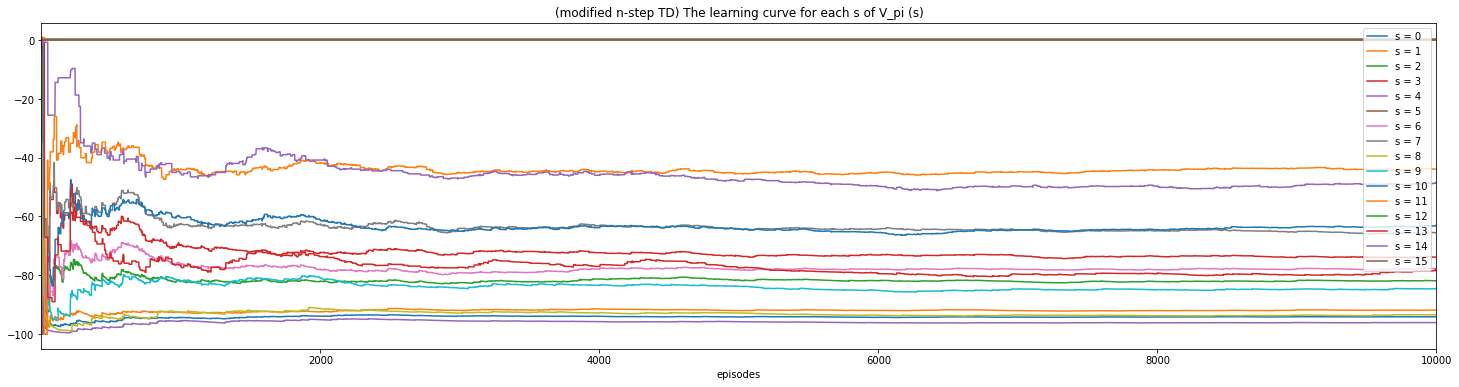

In [157]:
fig, ax = plt.subplots()
for state in range(Q25_plot.shape[0]):
  lbl = "s = " + str(state)
  ax.plot(np.arange(1, Q25_plot.shape[1]+1), Q25_plot[state], label = lbl)

ax.set_xlabel("episodes")
ax.set_xlim([1, Q25_plot.shape[1]])
ax.set_title("(modified n-step TD) The learning curve for each s of V_pi (s)")
ax.legend(loc='upper right')

#### 3 Temporal Difference Control Methods

In [158]:
env3 = FrozenLakeEnv(map_name="4x4", slip_rate=0.1)

##### Q1

In [159]:
def eps_greedy_action(eps, Q, current_state):

  randNumber = np.random.uniform(0,1)

  if randNumber >= eps:
    action = np.argmax(Q[current_state])
  else:
    action = np.random.choice(4, 1, p = [0.25, 0.25, 0.25, 0.25])[0]

  return action

In [160]:
def render_episode_from_Q(Q, env):

  current_state = env.reset()
  env.render()

  done = False
  while not done:
    action = np.argmax(Q[current_state])
    next_state, reward, done, extra = env.step(action)
    current_state = next_state
    env.render()

In [161]:
def SARSA_control(env, alpha, eps, nRuns, nEpisodes):

  gamma = 0.99
  average_return_Q31 = [0]*nEpisodes

  for run in range(nRuns):

    Q = np.random.random((16, 4))
    Q[15] = [0, 0, 0, 0]

    for epis in range(nEpisodes):

      print("\rRun number {}/{}, episode number {}/{}.".format(run, nRuns, epis, nEpisodes), end="")
      sys.stdout.flush()

      state = env.reset()
      action = eps_greedy_action(eps, Q, state)
      done = False

      while (done == False) and (state != 15):

        next_state, reward, done, _ = env.step(action)
        next_action = eps_greedy_action(eps, Q, next_state)
        average_return_Q31[epis] += reward
        Q[state][action] += alpha*( reward + gamma*Q[next_state][next_action] - Q[state][action] )
        action, state = next_action, next_state

  average_return_Q31 = list(np.array(average_return_Q31)/nRuns)
  return Q, average_return_Q31


In [162]:
Q_Q31, average_return_Q31 = SARSA_control(env3, alpha=0.1, eps=0.01, nRuns=10, nEpisodes=2000)

Run number 9/10, episode number 1999/2000.

Text(0.5, 1.0, '(SARSA) Average undiscounted return across the 10 different runs')

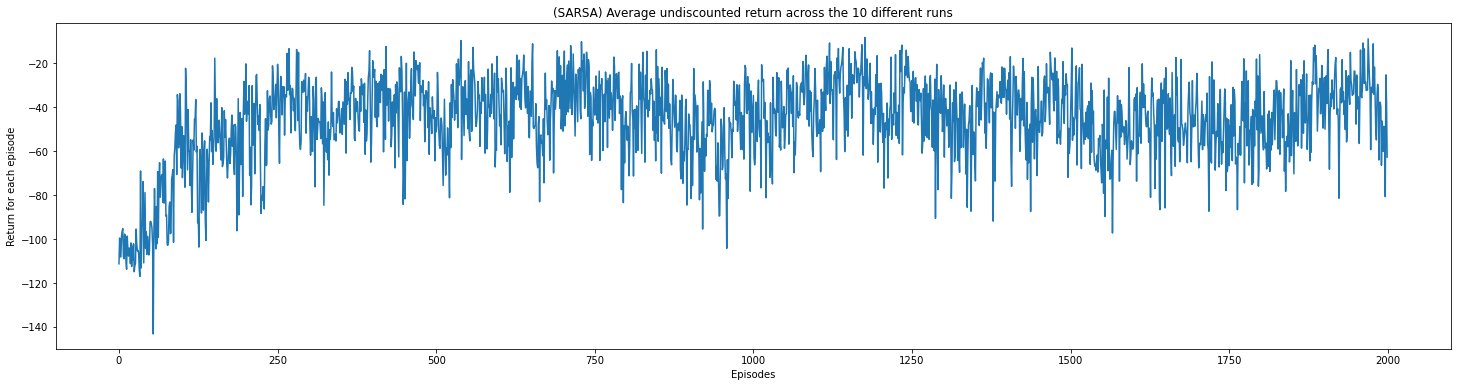

In [163]:
# Q3)1
fig, ax = plt.subplots()
ax.plot(range(2000), average_return_Q31)
ax.set_xlabel("Episodes")
ax.set_ylabel("Return for each episode")
ax.set_title("(SARSA) Average undiscounted return across the 10 different runs")

In [164]:
render_episode_from_Q(Q_Q31, env3)


SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG


##### Q2

In [165]:
def expected_SARSA_control(env, alpha, eps, nRuns, nEpisodes):

  gamma = 0.99
  average_return_Q32 = [0]*nEpisodes
  policy = generate_policy_b()

  for run in range(nRuns):

    Q = np.random.random((16, 4))
    Q[15] = [0, 0, 0, 0]

    for epis in range(nEpisodes):

      print("\rRun number {}/{}, episode number {}/{}.".format(run, nRuns, epis, nEpisodes), end="")
      sys.stdout.flush()

      state = env.reset()
      action = eps_greedy_action(eps, Q, state)
      done = False

      while (done == False) and (state != 15):

        next_state, reward, done, _ = env.step(action)
        next_action = eps_greedy_action(eps, Q, next_state)
        average_return_Q32[epis] += reward
        Q[state][action] += alpha*( reward + gamma*np.sum(policy[next_state]*Q[next_state]) - Q[state][action] )
        action, state = next_action, next_state

  average_return_Q32 = list(np.array(average_return_Q32)/nRuns)
  return Q, average_return_Q32


In [166]:
Q_Q32, average_return_Q32 = expected_SARSA_control(env3, alpha=0.2, eps=0.01, nRuns=10, nEpisodes=2000)

Run number 9/10, episode number 1999/2000.

Text(0.5, 1.0, '(Expected SARSA) Average undiscounted return across the 10 different runs')

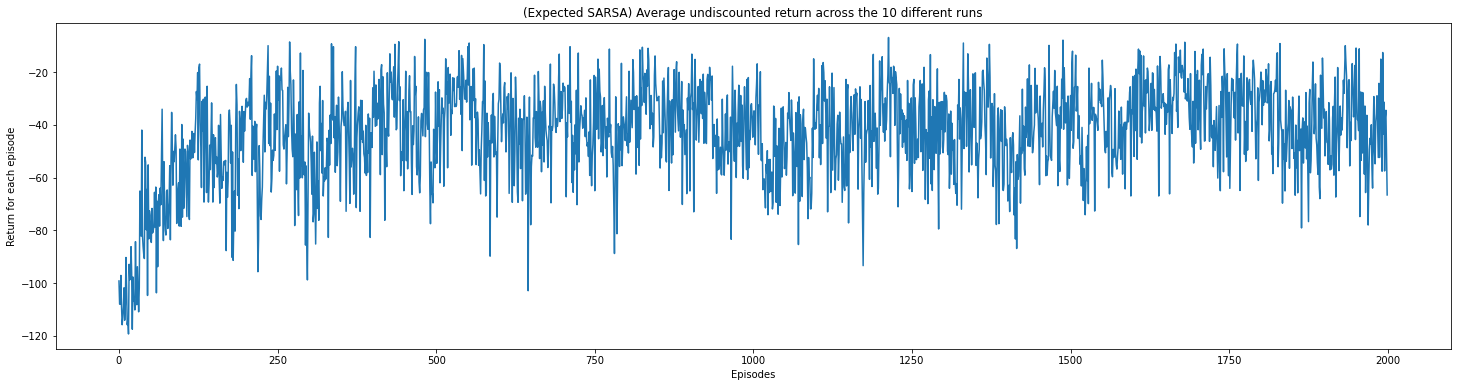

In [167]:
# Q3)2
fig, ax = plt.subplots()
ax.plot(range(2000), average_return_Q32)
ax.set_xlabel("Episodes")
ax.set_ylabel("Return for each episode")
ax.set_title("(Expected SARSA) Average undiscounted return across the 10 different runs")

In [168]:
render_episode_from_Q(Q_Q32, env3)


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG


##### Q3

In [169]:
def Q_learning(env, alpha, eps, nRuns, nEpisodes):

  gamma = 0.99
  average_return_Q33 = [0]*nEpisodes

  for run in range(nRuns):

    Q = np.random.random((16, 4))
    Q[15] = [0, 0, 0, 0]

    for epis in range(nEpisodes):

      print("\rRun number {}/{}, episode number {}/{}.".format(run, nRuns, epis, nEpisodes), end="")
      sys.stdout.flush()

      state = env.reset()
      action = eps_greedy_action(eps, Q, state)
      done = False

      while (done == False) and (state != 15):

        next_state, reward, done, _ = env.step(action)
        next_action = eps_greedy_action(eps, Q, next_state)
        average_return_Q33[epis] += reward
        Q[state][action] += alpha*( reward + gamma*max(Q[next_state]) - Q[state][action] )
        action, state = next_action, next_state

  average_return_Q33 = list(np.array(average_return_Q33)/nRuns)
  return Q, average_return_Q33


In [170]:
Q_Q33, average_return_Q33 = Q_learning(env3, alpha=0.1, eps=0.02, nRuns=10, nEpisodes=2000)

Run number 9/10, episode number 1999/2000.

Text(0.5, 1.0, '(Q-learning) Average undiscounted return across the 10 different runs')

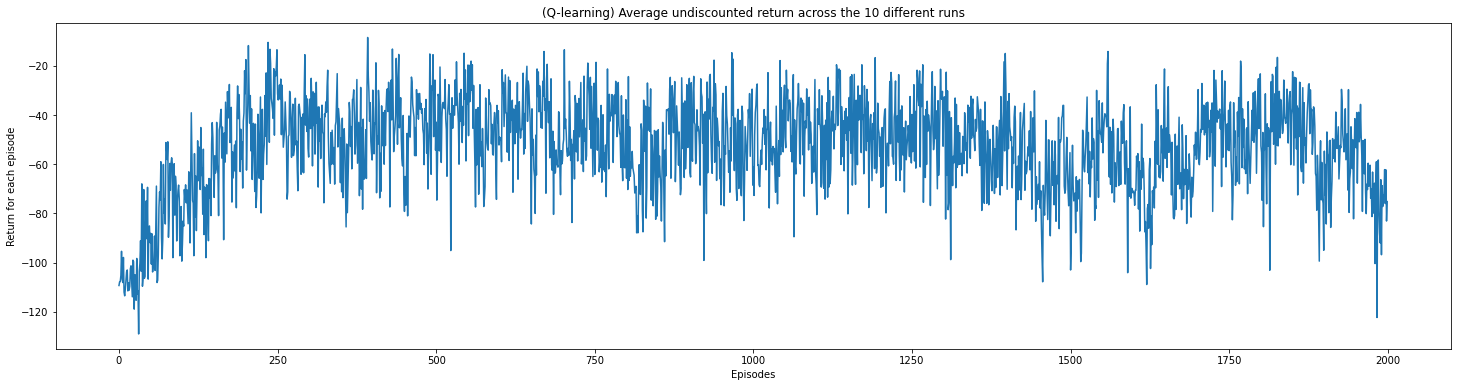

In [171]:
# Q3)3
fig, ax = plt.subplots()
ax.plot(range(2000), average_return_Q33)
ax.set_xlabel("Episodes")
ax.set_ylabel("Return for each episode")
ax.set_title("(Q-learning) Average undiscounted return across the 10 different runs")

In [172]:
render_episode_from_Q(Q_Q33, env3)


SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
